Name: Pranay Jain \
Roll number: AI22BTECH11020

In [589]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


## Activation function definitions

In [590]:
class Activation:
    ''' Contains definitions for various activation functions, namely, relu, sigmoid, tanh, prelu 
    
    Attributes
    ----------
    activation : str
        Activation function; can be one of `relu`, `sigmoid`, `tanh`, `prelu`
    '''
    
    def __init__(self, activation):
        self.activation = activation
        
    def activate(self, x, a=None):
        ''' Applies the activation function to the given input 

        Parameters
        ----------
        x : int or ndarray
            Input to be activated
        a : int
            Parameter used for `prelu` (Parametric ReLU)

        Returns
        -------
        int or ndarray
            Activated input
        '''
       
        if self.activation == 'relu':
            return np.maximum(x, 0)
        
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        
        elif self.activation == 'tanh':
            return np.tanh(x)
        
        elif self.activation == 'prelu':
            if a is not None:
                return x if x >= 0 else a * x
            else:
                return np.maximum(x, 0)
            
        else:
            raise ValueError(self.activation + ' is not a supported activation function. Possible choices are relu, sigmoid, tanh, prelu')

## Convolution function

In [591]:
def convolution(inputs, kernels, bias=None, stride=1, padding=0, activation='sigmoid', parameter=None):
    ''' Perform a convolution operation on the given input 

    Parameters
    ----------
    inputs : ndarray of shape (N, C, H, W)
        N : batch size (number of input images)
        C : number of channels in each image
        H : height of each image
        W : width of each image
    kernels : ndarray of shape (D, C, h, w)
        D : number of filters
        C : number of channels in each image
        h : height of kernel
        w : width of kernel
    bias : ndarray of shape (D,)
        Bias for each filter; if None, then no bias is considered
    stride : int or tuple of ints
        Stride of convolution along each dimension
    padding : int or tuple of ints
        Padding to be applied to the inputs along each dimension
    activation : str
        Activation function; can be one of `relu`, `sigmoid`, `tanh`, `prelu`
    parameter : int
        Parameter for the `prelu` activation function

    Returns
    -------
    ndarray of shape (N, D, H', W')
        Result of convolution of `inputs` with `kernels`
    '''
    
    N = inputs.shape[0]
    C = inputs.shape[1]
    H = inputs.shape[2]
    W = inputs.shape[3]
    
    D = kernels.shape[0]
    h = kernels.shape[2]
    w = kernels.shape[3]
    
    if kernels.shape[1] != C:
        raise ValueError('The kernels should have the same number of (in-)channels as the input')
        
    elif bias is not None and bias.shape[0] != D:
        raise ValueError('The number of bias terms should be equal to the number of kernels')
        
    # If `stride` is an integer, use same stride for both dimensions 
    if type(stride) == int:
        stride = (stride, stride)
    
    # If `padding` is an integer, use same padding for both dimensions
    if type(padding) == int:
        padding = (padding, padding)
    
    # Pad the inputs with 0 and compute output shape
    padded_inputs = np.pad(inputs, ((0,0), (0,0), (padding[0],padding[0]), (padding[1],padding[1])), 'constant')
    H_out = (H - h + 2*padding[0]) // stride[0] + 1
    W_out = (W - w + 2*padding[1]) // stride[1] + 1
    output = np.zeros((N, D, H_out, W_out))  
    
    for n in range(N):
        for d in range(D):
            kernel = kernels[d]
            for i in range(H_out):
                for j in range(W_out):

                    # Compute the element-wise product of the input region and kernel followed by adding all the elements in the product
                    output[n, d, i, j] = np.sum(np.multiply(kernel, padded_inputs[n, :, i*stride[0]:i*stride[0]+h, j*stride[1]:j*stride[1]+w]))
                    if bias is not None:
                        output[n, d, i, j] += bias[d] # Add bias to the weighted sum
                    
                    # Apply the non-linearity
                    nonlinearity = Activation(activation)
                    output[n, d, i, j] = nonlinearity.activate(output[n, d, i, j])
                        
    return output
            

### Testing with IIT-H logo

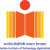

In [592]:
iith = Image.open('iith.jpg').convert('RGB')
iith

In [593]:
iith = np.array(iith).transpose((2, 0, 1))
iith = np.array([iith])
iith.shape

(1, 3, 50, 50)

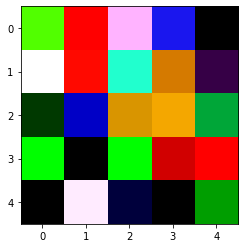

In [594]:
kernel = np.random.randn(1, 3, 5, 5)
plt.imshow(kernel.squeeze().transpose((1, 2, 0)))

<ipython-input-590-d9f47f75620f>:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


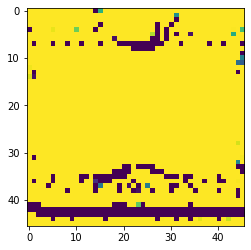

In [595]:
output = convolution(iith, kernel, activation='sigmoid')
plt.imshow(output.squeeze())

Observe that using the sigmoid activation causes an overflow for this image, which makes it unsuitable for this scenario

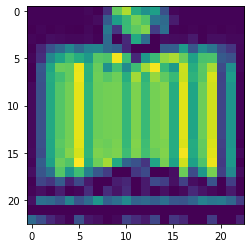

In [596]:
output = convolution(iith, kernel, stride=2, activation='relu')
plt.imshow(output.squeeze())

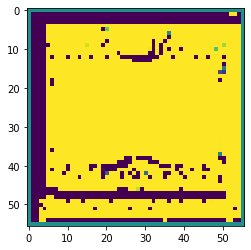

In [597]:
output = convolution(iith, kernel, padding=5, activation='tanh')
plt.imshow(output.squeeze())

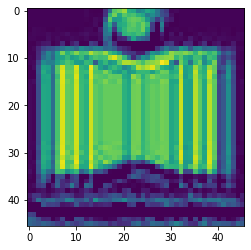

In [598]:
output = convolution(iith, kernel, activation='prelu', parameter=3)
plt.imshow(output.squeeze())

## Pooling function

In [599]:
def pooling(inputs, kernel_size, function='max', stride=None):
    ''' Perform a pooling operation on the given input 

    Parameters
    ----------
    inputs : ndarray of shape (N, C, H, W)
        N : batch size (number of input images)
        C : number of channels in each image
        H : height of each image
        W : width of each image
    kernel_size : int or tuple of ints
        Dimensions of the pooling kernel 
    function : str
        Pooling function to be used; can be one of `max`, `min`, `avg`
    stride : int or tuple of ints
        Stride of pooling along each dimension
  
    Returns
    -------
    ndarray of shape (N, C, H', W')
        Result of pooling of `inputs`
    '''
    
    N = inputs.shape[0]
    C = inputs.shape[1]
    H = inputs.shape[2]
    W = inputs.shape[3]
    
    # If `kernel_size` is an integer, use square kernel
    if type(kernel_size) == int:
        kernel_size = (kernel_size, kernel_size)
        
    h = kernel_size[0]
    w = kernel_size[1]
    
    # If `stride` is not specifically mentioned, pool in a contiguous non-overlapping manner (default)
    if stride is None:
        stride = kernel_size
    
    # If `stride` is an integer, use same stride for both dimensions
    if stride is not None and type(stride) == int:
        stride = (stride, stride)
      
    # Compute output shape
    H_out = H // stride[0]
    W_out = W // stride[1]
    output = np.zeros((N, C, H_out, W_out))
    
    for n in range(N):
        for c in range(C):
            for i in range(H_out):
                for j in range(W_out):
                    
                    # Max pooling
                    if function == 'max':
                        output[n, c, i, j] = np.max(inputs[n, c, i*stride[0]:i*stride[0]+h, j*stride[1]:j*stride[1]+w])
                    
                    # Min pooling
                    elif function == 'min':
                        output[n, c, i, j] = np.min(inputs[n, c, i*stride[0]:i*stride[0]+h, j*stride[1]:j*stride[1]+w])
                    
                    # Average pooling
                    elif function == 'avg':
                        output[n, c, i, j] = np.mean(inputs[n, c, i*stride[0]:i*stride[0]+h, j*stride[1]:j*stride[1]+w])
                        
                    else:
                        raise ValueError(function + ' is not a supported pooling function. Possible choices are max, min, avg')
                            
    return output


Text(0.5, 1.0, 'Before pooling')

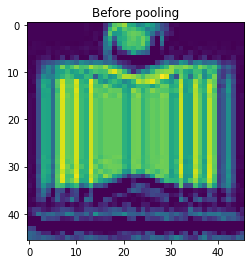

In [600]:
plt.imshow(output.squeeze())
plt.title('Before pooling')

Text(0.5, 1.0, 'After pooling')

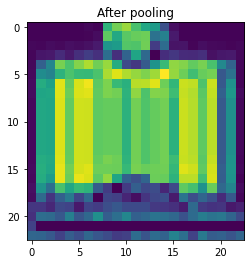

In [601]:
output = pooling(output, 2, 'max')
plt.imshow(output.squeeze())
plt.title('After pooling')

## Convolution layer

In [602]:
class ConvolutionLayer:
    ''' Convolution layer typically used in CNNs. Takes a batch of inputs and performs convolution on them using kernels of specified size.
    
    Attributes
    ----------
    num_channels : int
        Number of channels in the input images
    num_filters : int
        Number of filters required
    kernel_size : int or tuple of ints
        Dimensions of convolutional kernel
    stride : int or tuple of ints
        Stride of convolution along each dimension
    padding : int or tuple of ints
        Padding to be applied to the inputs along each dimension
    activation : str
        Activation function; can be one of `relu`, `sigmoid`, `tanh`, `prelu`
    parameter : int
        Parameter for the `prelu` activation function
    '''
    
    def __init__(self, num_channels, num_filters, kernel_size, stride=1, padding=0, activation='sigmoid', parameter=None):
        
        self.num_channels = num_channels
        self.num_filters = num_filters
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.parameter = parameter
        
        # If kernel_size is an integer, use a square kernel
        if type(kernel_size) == int:
            self.kernel_size = (kernel_size, kernel_size)
        else:
            self.kernel_size = kernel_size

        self.kernels = np.zeros((num_filters, num_channels, kernel_size[0], kernel_size[1]))
        self.bias = np.zeros(num_filters)
        
    def initialize_kernels(self, mode='standard'):
        ''' Randomly initialize kernels and bias based on one of three modes: `standard`, `xavier`, `msra` '''
        
        if mode == 'standard':
            std = 1
            self.bias = np.random.randn(self.num_filters)
            
        elif mode == 'xavier':
            std = 1 / np.sqrt(self.kernel_size[0] * self.kernel_size[1])
            self.bias = np.zeros(self.num_filters)
         
        elif mode == 'msra':
            std = np.sqrt(2 / (self.kernel_size[0] * self.kernel_size[1]))
            self.bias = np.zeros(self.num_filters)
            
        else:
            raise ValueError(mode + ' is not a supported initialization mode. Possible choices are standard, msra')
            
        self.kernels = np.random.randn(self.num_filters, self.num_channels, self.kernel_size[0], self.kernel_size[1]) * std
    
    def convolve(self, inputs):
        ''' Perform the convolution on `inputs` '''
        
        return convolution(inputs, self.kernels, self.bias, self.stride, self.padding, self.activation, self.parameter)
    

In [603]:
iith.shape

(1, 3, 50, 50)

In [604]:
conv = ConvolutionLayer(3, 10, (5,4), activation='relu')
conv.initialize_kernels()

In [605]:
conv.initialize_kernels()
output = conv.convolve(iith)
output.shape

(1, 10, 46, 47)

We can see that the output size is just as expected \
$1$  : number of input images \
$10$ : number of filters \
$46$ : height of output image $= 50 - 5 + 1$ \
$47$ : width of output image $= 50 - 4 + 1$ 

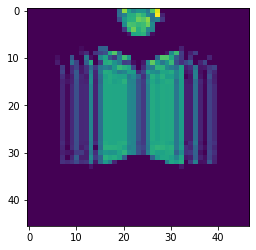

In [606]:
# Example of one of the filter outputs
plt.imshow(output.squeeze()[5])

## Pooling layer

In [607]:
class PoolingLayer:
    ''' Pooling layer typically used in CNNs. Takes a batch of inputs and pools them based on a pooling function.

    Attributes
    ----------
    kernel_size : int or tuple of ints
        Dimensions of the pooling kernel 
    function : str
        Pooling function to be used; can be one of `max`, `min`, `avg` or `gap` for Global Average Pooling
    stride : int or tuple of ints
        Stride of pooling along each dimension
    '''

    def __init__(self, kernel_size=None, function='max', stride=None):
        
        self.kernel_size = kernel_size
        self.function = function
        self.stride = stride
        
    def pool(self, inputs):
        
        # Global Average Pooling
        if self.function == 'gap' or self.kernel_size is None:
            return np.squeeze(pooling(inputs, (inputs.shape[2], inputs.shape[3]), 'avg'))
        
        # Regular pooling
        else:
            return pooling(inputs, self.kernel_size, self.function, self.stride)

In [608]:
# An example of Global Average Pooling
gap = PoolingLayer(function='gap')
gap.pool(output).shape

(10,)

which is as expected because the previous activation volume had $10$ channels, that got condensed into a $10$-element vector

In [609]:
# An example of max pooling
maxpool = PoolingLayer((2,2), 'max', stride=3)
output = maxpool.pool(output)
output.shape

(1, 10, 15, 15)

which is also as expected because $\left\lfloor \frac{46}{3} \right\rfloor = \left\lfloor \frac{47}{3} \right\rfloor = 15$

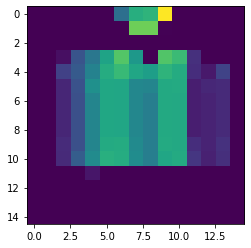

In [610]:
# An example of one of the pooled outputs
plt.imshow(output.squeeze()[5])

## Flattening

In [611]:
class FlatteningLayer:
    ''' Flatten an input volume into a vector of desired size 

    Attributes
    ----------
    input_size : int or ndarray
        Size of the input activation volume or the volume itself
    output_size : int
        Desired size of flattened output vector
    '''
    
    def __init__(self, input_size, output_size):
        
        if type(output_size) != int:
            raise TypeError('output_size must be an int')
        
        if type(input_size) != int:
            self.input_size = np.array(input_size).size
        else:
            self.input_size = input_size

        self.output_size = output_size
        self.weights = np.zeros((output_size, self.input_size))

    def initialize_weights(self, mode='standard'):
        ''' Initialize the weight matrix associated with the flattening transformation based on one of three modes: standard, xavier, msra '''
        
        if mode == 'standard':
            std = 1
            
        elif mode == 'xavier':
            std = 1 / np.sqrt(self.input_size)
            
        elif mode == 'msra':
            std = np.sqrt(2 / self.input_size)
            
        else:
            raise ValueError(mode + ' is not a supported initialization mode. Possible choices are standard, msra')
            
        self.weights = np.random.randn(self.output_size, self.input_size) * std
                   
        
    def flatten(self, inputs):
        ''' Flatten `inputs` '''
       
        unraveled_input = np.zeros(self.input_size)
        count = 0

        # Unravel the input volume into a vector
        for n in range(inputs.shape[0]):
            for c in range(inputs.shape[1]):
                for i in range(inputs.shape[2]):
                    for j in range(inputs.shape[3]):

                        unraveled_input[count] = inputs[n, c, i, j]
                        count += 1

        # If desired output size is the same as the size of the unraveled vector, no further transformation is required
        if self.input_size == self.output_size:
            return unraveled_input

        # Otherwise, multiply the unraveled vector with the weight matrix to get a vector of the desired size
        else:
            return self.weights @ unraveled_input


In [612]:
output.shape

(1, 10, 15, 15)

In [613]:
flat = FlatteningLayer(output.size, 100)
flat.initialize_weights()
output = flat.flatten(output)
output.shape

(100,)

Thus, a tensor containing $1 \times 10 \times 15 \times 15 = 2250$ elements has been flattened into a vector containing $100$ elements

## Multilayer perceptron

In [614]:
class MultilayerPerceptron:
    ''' A multilayer perceptron network consisting of several hidden layers 
    
    Attributes
    ----------
    input_size : int
        Number of neurons in the input layer
    output_size : int
        Number of neurons in the output layer
    hidden_sizes : List[int]
        List of the sizes of the hidden layers
    activation : str
        Activation function; can be one of `relu`, `sigmoid`, `tanh`, `prelu`
    parameter : int
        Parameter for the `prelu` activation function
    softmax : bool
        If True, softmax will be applied at the output layer
    '''
    
    def __init__(self, input_size, output_size, hidden_sizes, activation='sigmoid', parameter=None, softmax=True):
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes
        self.hidden_layers = len(hidden_sizes)
        self.activation = activation
        self.parameter = parameter
        self.softmax = softmax
        
        self.weights = []
        self.bias = []
        
    def initialize_weights(self, mode='standard'):
        ''' Initialize the weights and bias of the network using one of three modes: `standard`, `xavier`, `msra` '''
        
        if mode == 'standard':
            
            self.weights.append(np.random.randn(self.hidden_sizes[0], self.input_size))
            for i in range(1, self.hidden_layers):
                self.weights.append(np.random.randn(self.hidden_sizes[i], self.hidden_sizes[i-1]))
            self.weights.append(np.random.randn(self.output_size, self.hidden_sizes[-1]))
            
            for i in range(self.hidden_layers):
                self.bias.append(np.random.randn(self.hidden_sizes[i]))
            self.bias.append(np.random.randn(self.output_size))
        
        elif mode == 'xavier':
            
            self.weights.append(np.random.randn(self.hidden_sizes[0], self.input_size) / np.sqrt(self.input_size))
            for i in range(1, self.hidden_layers):
                self.weights.append(np.random.randn(self.hidden_sizes[i], self.hidden_sizes[i-1]) / np.sqrt(self.hidden_sizes[i-1]))
            self.weights.append(np.random.randn(self.output_size, self.hidden_sizes[-1]) / np.sqrt(self.hidden_sizes[-1]))
            
            for i in range(self.hidden_layers):
                self.bias.append(np.zeros(self.hidden_sizes[i]))
            self.bias.append(np.zeros(self.output_size))
            
        elif mode == 'msra':
            
            self.weights.append(np.random.randn(self.hidden_sizes[0], self.input_size) * np.sqrt(2 / self.input_size))
            for i in range(1, self.hidden_layers):
                self.weights.append(np.random.randn(self.hidden_sizes[i], self.hidden_sizes[i-1]) * np.sqrt(2 / self.hidden_sizes[i-1]))
            self.weights.append(np.random.randn(self.output_size, self.hidden_sizes[-1]) * np.sqrt(2 / self.hidden_sizes[-1]))
            
            for i in range(self.hidden_layers):
                self.bias.append(np.zeros(self.hidden_sizes[i]))
            self.bias.append(np.zeros(self.output_size))
            
        else:
            raise ValueError(mode + ' is not a supported initialization mode. Possible choices are standard, xavier, msra')
            
    
    def softmax_function(self, outputs):
        ''' Apply softmax to `outputs` '''
        
        # Find maximum value which will be subtracted from the exponents to prevent overflow
        # This is useful when the elements of `outputs` are very large
        # Note the softmax does not change when a fixed number is subtracted from the exponents
        max_element = np.max(outputs)

        # Total sum of the exponentials
        exp_sum = 0
        for output in outputs:
            exp_sum += np.exp(output - max_element)
    
        # Dividing each exponential by the total sum
        softmax_output = np.zeros(outputs.size)
        for i in range(outputs.size):
            softmax_output[i] = np.exp(outputs[i] - max_element) / exp_sum
            
        return softmax_output
    
    def forward_pass(self, inputs):
        ''' Forward pass of `inputs` through the entire MLP '''
        
        # Activation function
        nonlinearity = Activation(self.activation)
        output = np.copy(inputs)
        
        # Compute activations at each layer
        for i in range(len(self.weights) - 1):
            output = nonlinearity.activate(self.weights[i] @ output + self.bias[i])

        # Do not apply activation on the output layer
        output = self.weights[-1] @ output + self.bias[-1]
        
        if self.softmax:
            return self.softmax_function(output)
        
        else:
            return output    
    

Softmax in case of large numbers can be calculated as
$$ \frac{e^{x_i}}{\sum e^{x_i}} = \frac{e^{-M}e^{x_i}}{e^{-M}\sum e^{x_i}} = \frac{e^{x_i - M}}{\sum e^{x_i - M}} $$
I have chosen $M$ to be $M = \max x_i$ so that there are no big numbers anymore, only non-positive numbers are present

In [615]:
# Output without softmax
mlp = MultilayerPerceptron(100, 10, [256, 128], activation='relu', softmax=False)
mlp.initialize_weights()
mlp.forward_pass(output)

array([-40209583.50091635, -30630885.74823042,  34681964.44195525,
        43230122.09479322,  -9876701.02841351, -12945909.82141238,
       -58669905.45992647,   1755144.29410684, -61150135.28372177,
       -32979871.94060706])

Notice that without softmax, the magnitudes of the outputs are very large

In [616]:
# Output with softmax
mlp = MultilayerPerceptron(100, 10, [256, 128], activation='relu', softmax=True)
mlp.initialize_weights()
mlp.forward_pass(output)

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

There is only one $1$ in the output and the rest are zeroes because one of the output numbers was much larger than the others, which caused its exponential to dominate. In cases like these, the predicted label for the input becomes very clear.

## Feed forward path

In [617]:
class ConvolutionalNeuralNetwork:
    ''' Implementation of a full convolutional neural network 
    
    Attributes
    ----------
    model : List of layer objects
        A list consisting of the various layers in a CNN in order with the desired parameters
    '''
    
    def __init__(self, model):
        
        self.model = model

    def initialize_weights(self):
        ''' Initialize the weights in all the layers in the model '''

        for layer in self.model:
            
            if type(layer) == ConvolutionLayer:
                layer.initialize_kernels('standard')
             
            elif type(layer) == FlatteningLayer:
                layer.initialize_weights('msra')
                
            elif type(layer) == MultilayerPerceptron:
                layer.initialize_weights('xavier')
        
    def feed_forward(self, inputs):
        ''' Feed forward pass through the entire CNN '''
        
        output = np.copy(inputs)
        
        for layer in self.model:
            
            if type(layer) == ConvolutionLayer:
                output = layer.convolve(output)
                
            elif type(layer) == PoolingLayer:
                output = layer.pool(output)
                
            elif type(layer) == FlatteningLayer:
                output = layer.flatten(output)
                
            elif type(layer) == MultilayerPerceptron:
                output = layer.forward_pass(output)
                
        return output

### Model definition

In [618]:
model = [
    ConvolutionLayer(3, 16, (3,3), activation='sigmoid'),
    PoolingLayer((2,2), 'max', stride=2),
    ConvolutionLayer(16, 8, (3,3), activation='sigmoid'),
    PoolingLayer((2,2), 'max', stride=2),
    PoolingLayer(function='gap'),
    MultilayerPerceptron(8, 10, [8], activation='sigmoid', softmax=True)
]

cnn = ConvolutionalNeuralNetwork(model)
cnn.initialize_weights()

In [619]:
sample_input = np.random.randn(1, 3, 32, 32)
cnn.feed_forward(sample_input)

array([0.09014825, 0.06712615, 0.27570548, 0.09113668, 0.13503372,
       0.03155679, 0.03458249, 0.02748823, 0.07247213, 0.17475008])

## CIFAR-10 testing

### Loading the dataset

In [620]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor()])
batch_size = 1

dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
datalist = list(dataloader)

Files already downloaded and verified


torch.Size([1, 3, 32, 32])
[0.08959214 0.06686905 0.2810067  0.08897933 0.13385271 0.03173595
 0.03348997 0.02914968 0.0721741  0.17315036]


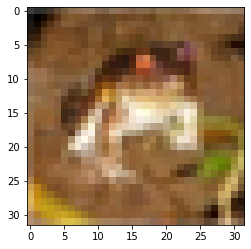

In [621]:
# Verifying if the CNN model takes an image input and produces a 10-element vector
image = datalist[0][0]
plt.imshow(torch.permute(image.squeeze(), (1, 2, 0)).numpy())
print(image.shape)
print(cnn.feed_forward(image.numpy()))

We can see that the CNN produces a vector consisting of $10$ elements

### Output for an image from each class

[0.09153395 0.06703983 0.27202577 0.08913083 0.13528312 0.03350205
 0.03479033 0.02947142 0.07377214 0.17345057]


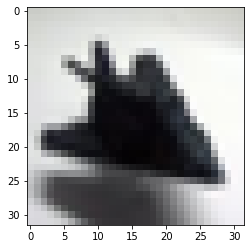

In [622]:
for i in range(len(datalist)):
    if datalist[i][1].item() == 0:
        plt.imshow(torch.permute(datalist[i][0].squeeze(), (1, 2, 0)).numpy())
        print(cnn.feed_forward(datalist[i][0].numpy()))
        break

[0.09311814 0.0672407  0.26550549 0.08940034 0.13594857 0.03475995
 0.03581968 0.02965845 0.07472893 0.17381974]


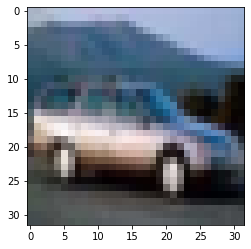

In [623]:
for i in range(len(datalist)):
    if datalist[i][1].item() == 1:
        plt.imshow(torch.permute(datalist[i][0].squeeze(), (1, 2, 0)).numpy())
        print(cnn.feed_forward(datalist[i][0].numpy()))
        break

[0.08968555 0.06717118 0.2756019  0.08895511 0.13761791 0.03276826
 0.03429993 0.02899152 0.07488683 0.17002181]


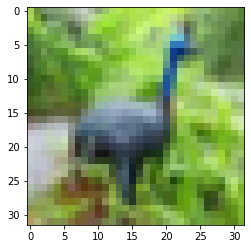

In [624]:
for i in range(len(datalist)):
    if datalist[i][1].item() == 2:
        plt.imshow(torch.permute(datalist[i][0].squeeze(), (1, 2, 0)).numpy())
        print(cnn.feed_forward(datalist[i][0].numpy()))
        break

[0.09055059 0.06658077 0.28190219 0.08826532 0.13052768 0.03202411
 0.03316714 0.03044996 0.07032624 0.17620602]


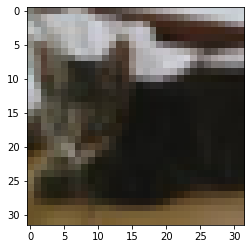

In [625]:
for i in range(len(datalist)):
    if datalist[i][1].item() == 3:
        plt.imshow(torch.permute(datalist[i][0].squeeze(), (1, 2, 0)).numpy())
        print(cnn.feed_forward(datalist[i][0].numpy()))
        break

[0.08997497 0.06663587 0.28287218 0.0884762  0.13131317 0.03169551
 0.03308582 0.02999015 0.07065813 0.17529799]


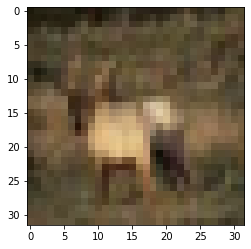

In [626]:
for i in range(len(datalist)):
    if datalist[i][1].item() == 4:
        plt.imshow(torch.permute(datalist[i][0].squeeze(), (1, 2, 0)).numpy())
        print(cnn.feed_forward(datalist[i][0].numpy()))
        break

[0.09131607 0.06659222 0.27856643 0.08882355 0.13094534 0.03241626
 0.03375674 0.0299144  0.07074315 0.17692583]


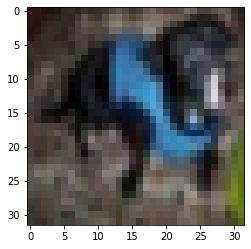

In [627]:
for i in range(len(datalist)):
    if datalist[i][1].item() == 5:
        plt.imshow(torch.permute(datalist[i][0].squeeze(), (1, 2, 0)).numpy())
        print(cnn.feed_forward(datalist[i][0].numpy()))
        break

[0.08959214 0.06686905 0.2810067  0.08897933 0.13385271 0.03173595
 0.03348997 0.02914968 0.0721741  0.17315036]


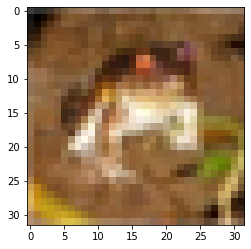

In [628]:
for i in range(len(datalist)):
    if datalist[i][1].item() == 6:
        plt.imshow(torch.permute(datalist[i][0].squeeze(), (1, 2, 0)).numpy())
        print(cnn.feed_forward(datalist[i][0].numpy()))
        break

[0.08995225 0.06696221 0.27772288 0.08903757 0.13530956 0.03235312
 0.03398294 0.02906864 0.07331476 0.17229608]


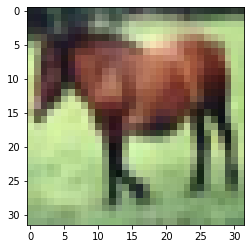

In [629]:
for i in range(len(datalist)):
    if datalist[i][1].item() == 7:
        plt.imshow(torch.permute(datalist[i][0].squeeze(), (1, 2, 0)).numpy())
        print(cnn.feed_forward(datalist[i][0].numpy()))
        break

[0.0943102  0.06812385 0.25248203 0.08929167 0.1420791  0.03760283
 0.03785056 0.03016255 0.07983551 0.1682617 ]


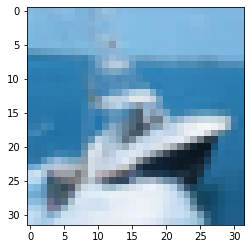

In [630]:
for i in range(len(datalist)):
    if datalist[i][1].item() == 8:
        plt.imshow(torch.permute(datalist[i][0].squeeze(), (1, 2, 0)).numpy())
        print(cnn.feed_forward(datalist[i][0].numpy()))
        break

[0.0918706  0.067469   0.26568925 0.08929243 0.13900843 0.03467197
 0.03579241 0.02929825 0.0765694  0.17033827]


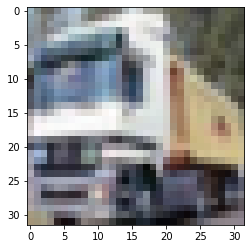

In [631]:
for i in range(len(datalist)):
    if datalist[i][1].item() == 9:
        plt.imshow(torch.permute(datalist[i][0].squeeze(), (1, 2, 0)).numpy())
        print(cnn.feed_forward(datalist[i][0].numpy()))
        break

We can see that no matter which class the image is from, the output vector is approximately the same for all. This is perhaps because the kernels and weights are randomly initialized using Xavier and MSRA initialization. Standard initialization gives considerable variance in each of the output vectors.

### Visualizing the bottleneck layer

In [632]:
# Output of the bottleneck_model will be the output of Global Average Pooling layer which is the flattening layer here
bottleneck_model = [
    ConvolutionLayer(3, 16, (3,3), activation='sigmoid'),
    PoolingLayer((2,2), 'max', stride=2),
    ConvolutionLayer(16, 8, (3,3), activation='sigmoid'),
    PoolingLayer((2,2), 'max', stride=2),
    PoolingLayer(function='gap')
]

bottleneck_cnn = ConvolutionalNeuralNetwork(bottleneck_model)
bottleneck_cnn.initialize_weights()

In [633]:
from sklearn.decomposition import PCA

# Reduce dimensionality to 2 for plotting
pca = PCA(n_components=2)
bottleneck_data = []

# Add 3 images from each class to `bottleneck_data`
for c in range(10):

    count = 0
    for i in range(len(datalist)):

        if datalist[i][1].item() == c:
            bottleneck_data.append(bottleneck_cnn.feed_forward(datalist[i][0].numpy()))
            count += 1
        
        if count == 3:
            break

pca_output = pca.fit_transform(np.array(bottleneck_data))
pca_output.shape

(30, 2)

Text(0.5, 1.0, 'Plot of bottleneck layer output (after PCA)')

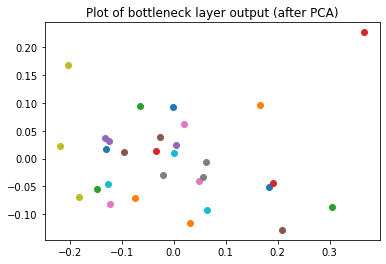

In [634]:
# Each class has its own dot colour
for i in range(10):
    plt.scatter(pca_output[i*3:(i+1)*3, 0], pca_output[i*3:(i+1)*3, 1])
plt.title('Plot of bottleneck layer output (after PCA)')

A randomly initialized network does not show any discriminability as we have already seen that the network produces nearly the same output for every class. This is also evident from the above plot where the bottleneck output seems to be arbitrarily scattered irrespective of the class the input belongs to.